In [1]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

import pandas as pd

df = pd.read_csv('data.csv')

In [2]:
df.head()

,x,y
0,0.725708,8.041778
1,-0.390810,-10.459451
2,-1.769738,-25.287686
3,1.923968,-9.023523
4,0.028524,10.035387


In [3]:
df.shape

(1000, 2)

In [4]:
x = df[['x']]
y = df[['y']]

x.shape

(1000, 1)

In [5]:
y.shape

(1000, 1)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

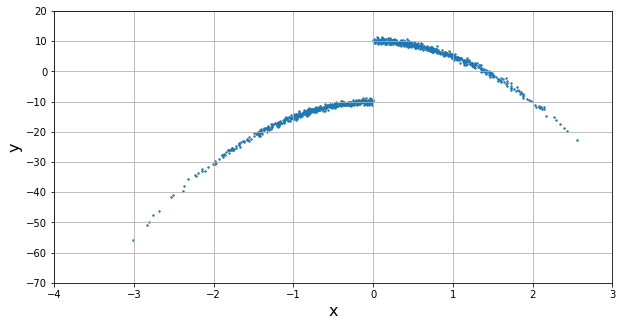

In [7]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.scatter(x, y, s = 2)
plt.xlabel('x', fontsize=16)
plt.xlim([-4, 3])
plt.ylim([-70, 20])
plt.ylabel('y', fontsize=16)
plt.show()


In [8]:
x_new=np.c_[np.ones((len(x),1)),x,x**2, x**3, x**4, abs(x), np.sign(x), np.sin(x), np.cos(x), np.exp(x)]
x_new.shape


(1000, 10)

<h1>Algorithmic Approach<h1>

## Forward Selection

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=123)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [11]:
def forward_selection(x_train, x_test, y_train, y_test, significance_level=0.05):
    lin_reg=LinearRegression(fit_intercept=False)
    initial_features = list(range(len(x_train[0])))
    best_features = []
    min_error=100
    while (len(initial_features)>0):

        remaining_features = list(set(initial_features)-set(best_features))

        temp_len=len(best_features)
        for new_column in remaining_features:

            lin_reg.fit((x_train[:,best_features+[new_column]]),y_train)
            y_predict=lin_reg.predict(x_test[:,best_features+[new_column]])
            current_error=mean_squared_error(y_predict,y_test)
           
            if(current_error<min_error):
                best_feature=new_column
                min_error=current_error
        if(len(best_features)==2):
            break
        if(best_feature not in best_features):
            best_features.append(best_feature)
        else:
            break

        print(best_features)
   
    r2_score_=r2_score(y_test,y_predict)
    print("r2_score for Forward Selection ",r2_score_)


    return best_features,initial_features,min_error

In [12]:
best_features,initial_features,min_error=forward_selection(x_train, x_test, y_train, y_test)

[6]
[6, 2]
r2_score for Forward Selection  0.9977977491843558


In [13]:
best_features

[6, 2]

In [14]:
print("Minimum Error for Forward Selection: ",min_error)

Minimum Error for Forward Selection:  0.29376397291356215


**Comment:** 
At first it initialize empty array to hold best_features.It removes best_features that it determined from initial_features.That way, it doesn't check for those features again.Then in remaining_features it fit the model with that best_features and calculates the mean_squared_error.If the current_error less than min_error than it assign the best_feature and min_error. Later if best_features list doesn't contains best_feature, it add this best_feature. Finally it calculates R squared error.Using dimensionality reduction, we can significantly speed up model training and validation, saving time, as well as greatly reducing the risk of overfitting.

<h1>Mathematical Approach<h1>

In [15]:
from sklearn import linear_model
# Find LASSO paths (LASSO coeffections for different alpha values)
n_alphas = 100
lasso_alphas = np.linspace(1, 100, n_alphas)

X_new = StandardScaler().fit_transform(x_new)

lasso_coefs = []
for a in lasso_alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False, max_iter=10000)
    lasso.fit(X_new, y)
    lasso_coefs.append(lasso.coef_)

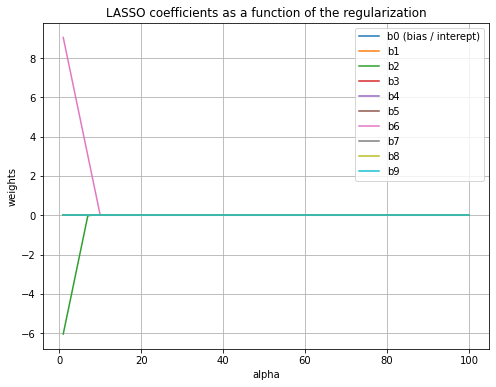

In [16]:
plt.figure(2, figsize=(8,6))    
plt.plot(lasso_alphas, lasso_coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
plt.legend(('b0 (bias / interept)', 'b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9'))
plt.grid()
plt.show()

In [17]:
lasso_alphas.shape

(100,)

<h1>Choosing best alpha for LASSO<h1>

In [18]:
from sklearn.linear_model import LassoCV

# use 10 fold cross-validation to find best alpha
n_alphas = 100
lasso_alphas = np.linspace(1, 10, n_alphas)

X_new = StandardScaler().fit_transform(x_new)

foldCount = 10
lassocv = LassoCV(cv=foldCount, alphas=lasso_alphas, fit_intercept=True, max_iter=10000, random_state=0)
lassocv.fit(X_new, y.values.ravel())

# show best result
print('Best alpha = ', lassocv.alpha_)
print()

print('Best coefficients = ', lassocv.coef_)
print()

print('Best R^2 score = ', lassocv.score(X_new, y))
print()

Best alpha =  1.0

Best coefficients =  [ 0.          0.         -6.03732071  0.         -0.         -0.
  9.04170656  0.          0.         -0.        ]

Best R^2 score =  0.9848858168997807



In [19]:
nonzero_coefs=lassocv.coef_ !=0
best_coeff=lassocv.coef_
reduced_features=X_new[:,nonzero_coefs] 
reduced_coefs=best_coeff[nonzero_coefs]
y_pred=reduced_features.dot(reduced_coefs[np.newaxis,:].T)
current_error=mean_squared_error(y_pred,y)
print("Minimum Error for Lasso: ",current_error)

Minimum Error for Lasso:  24.020751073009706


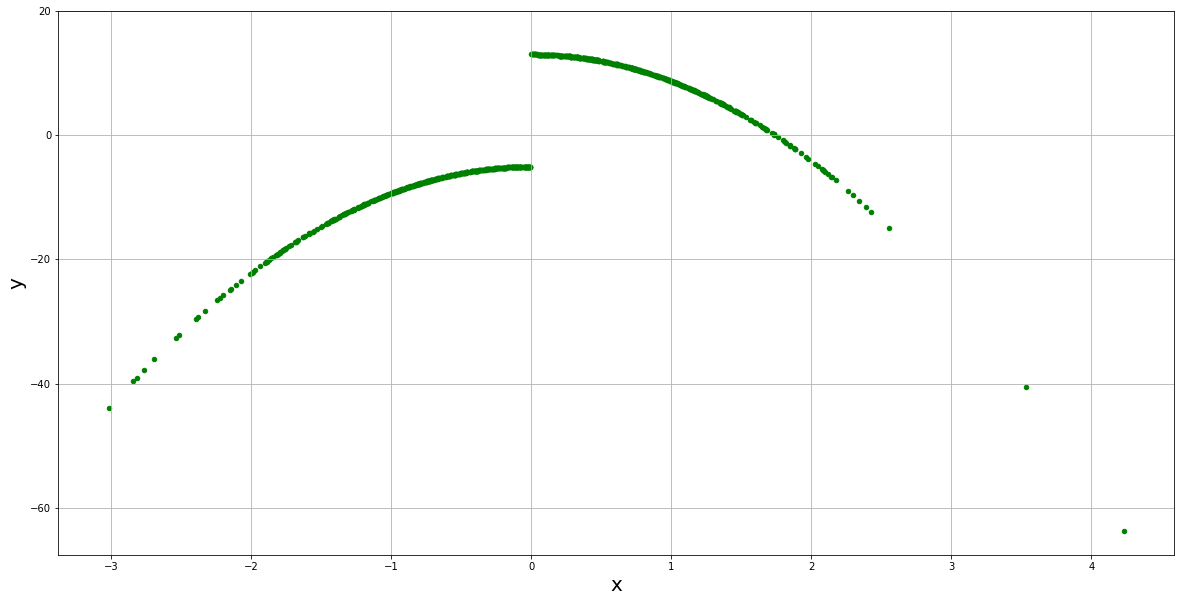

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(x, y_pred, s = 20,color="green")
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)


plt.yticks(range(-60,40,20))

plt.grid()
plt.show()


**Comment:** 
Lasso has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task.Just like Ridge Regression Lasso regression also trades off an increase in bias with a decrease variance.Lasso forces some of the coefficient estimates to be exactly equal to zero when the tuning parameter λ is sufficiently large.Ridge regression can’t make coefficients zero . Here, you either select all the coefficients or none of them whereas LASSO does both parameter shrinkage and variable selection automatically because it zero out the coefficients of collinear variables.

<h1>Plane<h1>

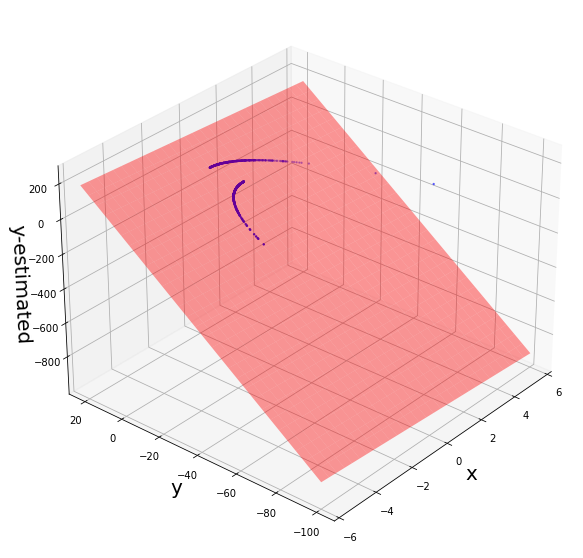

In [21]:
m = 30
xx, yy = np.meshgrid(np.linspace(-6, 6, m), np.linspace(-100, 20, m))

Xg = np.c_[xx.flatten(), yy.flatten()]
zz=Xg.dot(reduced_coefs[np.newaxis,:].T)
zz=zz.reshape(m,m)
ax = plt.figure(figsize=(12, 10)).gca(projection='3d')

ax.plot_surface(xx, yy, zz, alpha=0.4,color='red', shade=False)
ax.scatter(x,y_pred,color='blue', s=2)

ax.set_xlabel("x",fontsize=20)
ax.set_ylabel("y",fontsize=20)
ax.set_zlabel("y-estimated",fontsize=20)

ax.view_init(elev=30, azim=220)
ax.set_xlim3d([-6,6])



plt.show()